In [1]:
import pandas as pd 
import os, glob
import matplotlib.pyplot as plt 
import numpy as np
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
df = pd.concat((pd.read_csv(f, engine="python") for f in glob.glob(r"gemini_BTCUSD_20[12][90]*.csv")))
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d %H:%M:%S")
df = df.drop(["Symbol", "Unix Timestamp"], axis=1)
df = df.resample("1T", on="Date").agg({"Open": "first", "Close": "last", "Volume": np.sum, "High": np.max, "Low": np.min})

# df = df.drop("Date", axis=1)
df["diff"] = (df["Close"] - df["Open"])/df["Close"]
df["inc"] = df["diff"].apply(lambda x: 1 if x > 0 else 0)
df["dec"] = df["diff"].apply(lambda x: 0 if x > 0 else 1)
# df["Close"] = df["Close"] - np.mean(df["Close"])
# df["Open"] = df["Open"] - np.mean(df["Open"])
# df["Volume"] = df["Volume"] - np.mean(df["Volume"])
# df["Low"] = df["Low"] - np.mean(df["Low"])
# df["High"] = df["High"] - np.mean(df["High"])
df.dropna()
df.head()

,Open,Close,Volume,High,Low,diff,inc
Date,,,,,,,
2019-01-01 00:00:00,-7486.848425,-7484.247455,-0.592268,-7490.327589,-7480.784453,0.000717,1
2019-01-01 00:01:00,-7484.198425,-7489.577455,-1.425867,-7490.327589,-7483.464453,-0.001445,0
2019-01-01 00:02:00,-7489.528425,-7489.747455,-1.428937,-7495.657589,-7483.634453,-0.000046,0
2019-01-01 00:03:00,-7489.698425,-7488.037455,-0.399129,-7494.117589,-7483.634453,0.000463,1
2019-01-01 00:04:00,-7487.988425,-7488.037455,-1.430040,-7494.117589,-7481.924453,0.000000,0


In [3]:
def split_dataset(dataset, split=2/3):
    train_size = int(len(dataset) * split)
    test_size = len(dataset) - train_size
    print(train_size, test_size)
    train = dataset[:train_size]
    test = dataset[train_size:]
    return train, test

In [28]:

train, test = split_dataset(df);
print(train.head())

y = train["inc"].apply(lambda x: [0, 1] if x == 1 else [1, 0])
len(train)
train_generator = TimeseriesGenerator(train.to_numpy(), train["inc"].apply(lambda x: [0, 1] if x == 1 else [1, 0]), length=360, batch_size=512)
test_generator = TimeseriesGenerator(test.to_numpy(), test["inc"].apply(lambda x: [0, 1] if x == 1 else [1, 0]), length=360, batch_size=512)
print(len(train_generator))
print(train_generator[1])


749762 374881
                            Open        Close    Volume         High  \
Date                                                                   
2019-01-01 00:00:00 -7486.848425 -7484.247455 -0.592268 -7490.327589   
2019-01-01 00:01:00 -7484.198425 -7489.577455 -1.425867 -7490.327589   
2019-01-01 00:02:00 -7489.528425 -7489.747455 -1.428937 -7495.657589   
2019-01-01 00:03:00 -7489.698425 -7488.037455 -0.399129 -7494.117589   
2019-01-01 00:04:00 -7487.988425 -7488.037455 -1.430040 -7494.117589   

                             Low      diff  inc  
Date                                             
2019-01-01 00:00:00 -7480.784453  0.000717    1  
2019-01-01 00:01:00 -7483.464453 -0.001445    0  
2019-01-01 00:02:00 -7483.634453 -0.000046    0  
2019-01-01 00:03:00 -7483.634453  0.000463    1  
2019-01-01 00:04:00 -7481.924453  0.000000    0  
1464
(array([[[-7.46133842e+03, -7.45788745e+03, -1.07574158e+00, ...,
         -7.45527445e+03,  9.40516370e-04,  1.00000000e+00],

In [21]:
from tensorflow.keras import models
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.losses import BinaryCrossentropy, MeanAbsoluteError


model = models.Sequential()
# model.add(Input(shape=train_generator[0][0].shape))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
model.add(LSTM(units=16))
model.add(Dropout(.2))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(2, activation="softmax"))
model.compile("adam", BinaryCrossentropy())
model.fit(train_generator, epochs=1)
model.summary()


1464/1464 [==============================] - 301s 205ms/step - loss: 0.6392
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, None, 256)         139264    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, None, 128)         164352    
_________________________________________________________________
bidirectional_14 (Bidirectio (None, None, 64)          41216     
_________________________________________________________________
lstm_19 (LSTM)               (None, 16)                5184      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                1088      
____________________________________________

In [31]:
predictions = model.predict(test_generator)

array([0.33491132, 0.6650887 ], dtype=float32)

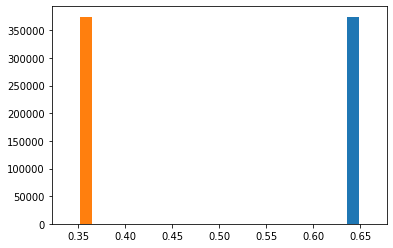

In [32]:
plt.hist(predictions)
np.unique(predictions)